## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [3]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/ecol/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/ecol/'
gtf_name = 'Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.51.gtf'
mutation = 'efp'
samp_num = '1'
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [4]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [5]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [6]:
# clear up some memory by deleting original transcript list
transcripts.clear()

# Loading up the csv file.

In [7]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

## Determine KS statistic for all transcripts

In [9]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == True:
    ks_list = []
    p_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, transcript in zip(data_mutant, data_control, protein_coding):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5:
            position = np.array(list(range(len(tr_m))))
            smoothed_vec_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.00000000001)
            smoothed_vec_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.00000000001)
            ks = max(abs(cumul_m - cumul_c))
            ks_list.append(ks)
            #p_list.append(p)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            

    # Calculate the -10 log of the P values in order to visualize the smallest values. 
    #log_p = []
    #for p in p_list:
    #    if p != 0:
    #        log_p.append(math.log(p, 0.1))
    #    else:
    #        log_p.append(200)
            
    # reorganizing the lists into a dataframe. 
    df = pd.DataFrame(list(zip(p_list, log_p, ks_list, gene_list, tr_id)))
    df.columns = ["ks_stat", "gene_ID","transcript_ID"]

NameError: name 'log_p' is not defined

In [12]:
# Save as a csv
#df.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

In [49]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

In [25]:
# print out all of the genes with P-values below a certain threshold. 
diff_dist = list(zip(df["transcript_ID"][df['ks_stat'] > 0.4],df["gene_ID"][df['ks_stat'] > 0.4]))

In [26]:
def big_dif(diff_dist, transcripts, data_mutant, data_control, figsize = (16,50), fontsize = 12):
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, gi in zip(ax, diff_dist):
            my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts(gi[1], 
                                           protein_coding, data_mutant, data_control)
            maxi = max([max(my_vec_mutant), max(my_vec_control)])

            axi[0].plot(my_vec_mutant)
            axi[0].set_ylim([0,maxi+5])
            axi[0].set_title("mutant " + gi[1], fontsize = fontsize)
            axi[1].plot(my_vec_control)
            axi[1].set_ylim([0,maxi+5])
            axi[1].set_title("control " + gi[1], fontsize = fontsize)
            
    return ax

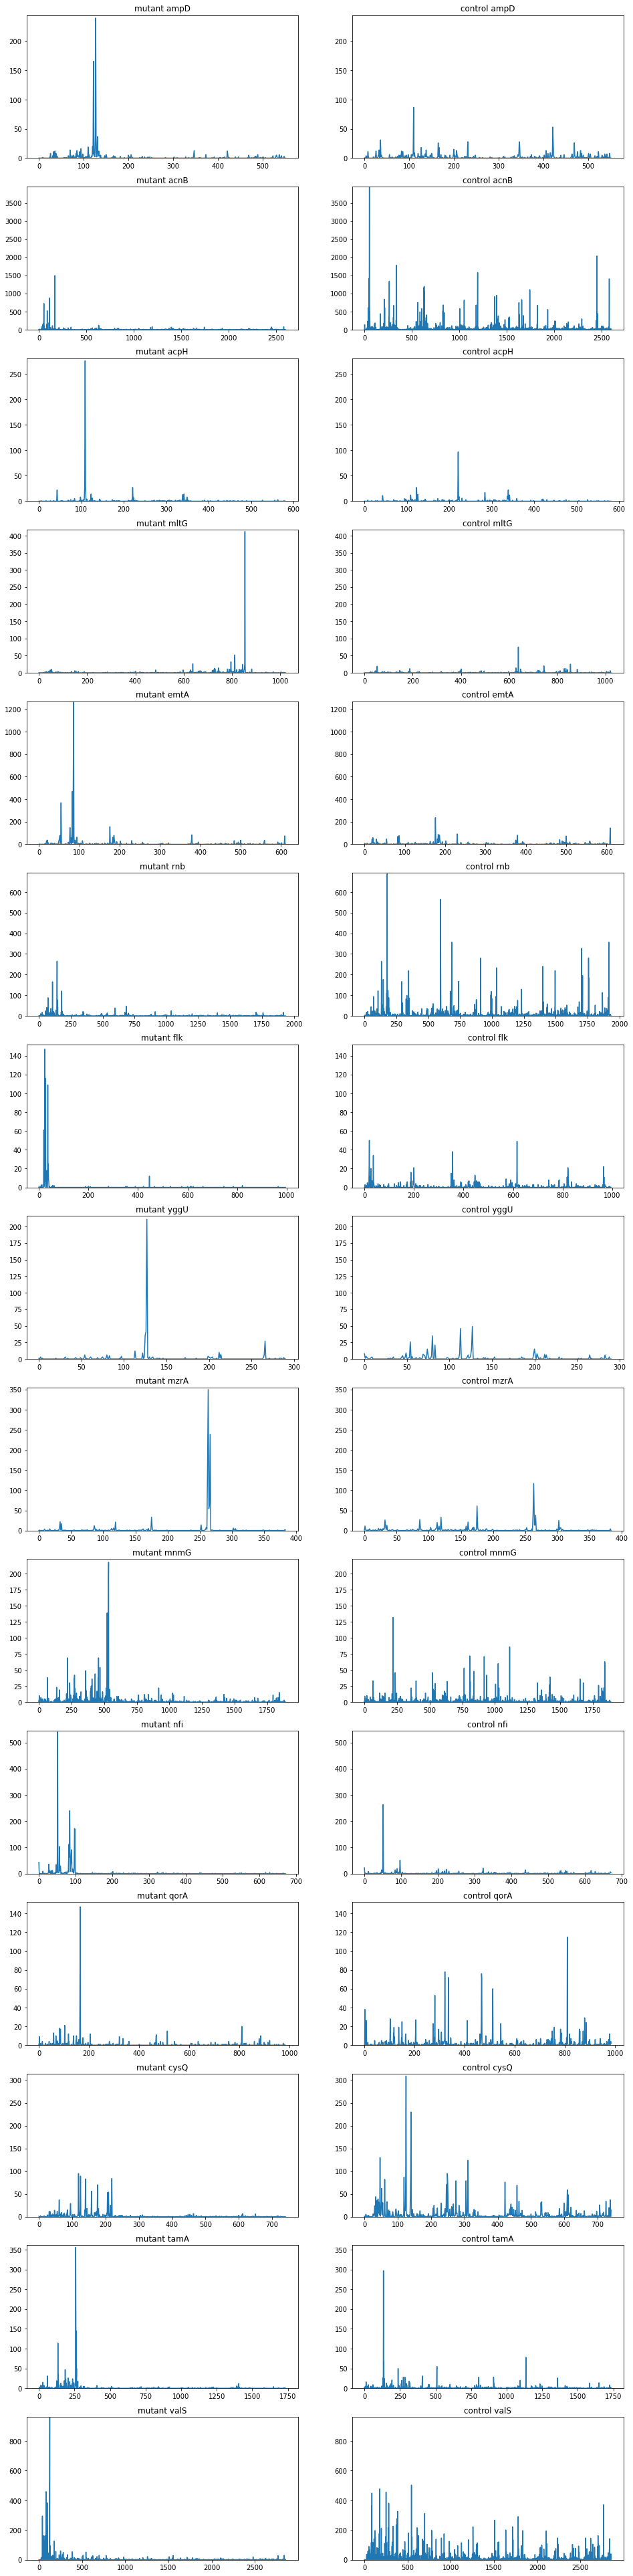

In [27]:
ax = big_dif(diff_dist, transcripts, data_mutant, data_control, figsize = (16,70), fontsize = 12)

Text(0.5, 1.0, 'KS statistic of all mouse transcripts')

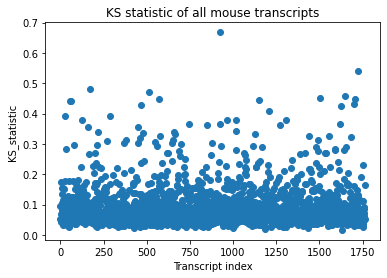

In [10]:
plt.scatter(list(range(len(ks_list))), ks_list)
plt.ylabel("KS_statistic")
plt.xlabel("Transcript index")
plt.title("KS statistic of all mouse transcripts")

Text(0.5, 1.0, '-10log transformed p-values of all KS tests (mouse)')

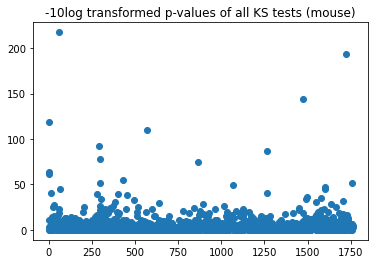

In [30]:
plt.scatter(list(range(len(log_p))), log_p)
#plt.ylabel("P-value")
#plt.xlabel("Transcript index")
plt.title("-10log transformed p-values of all KS tests (mouse)")
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

## Choose the gene of interest and smooth out the array.

In [33]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts('thrC', 
                                           protein_coding, data_mutant, data_control)

In [34]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [35]:
sum(my_vec_control)/len(my_vec_control)

63.51748251748252

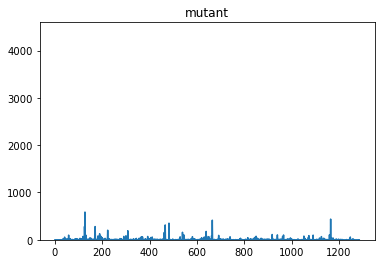

Text(0.5, 1.0, 'control')

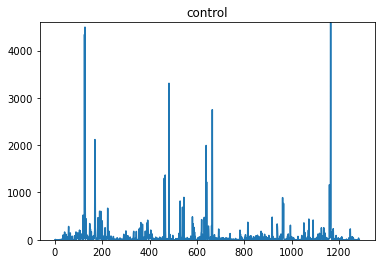

In [36]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.plot(my_vec_mutant)
plt.ylim([0,maxi+5])
plt.title("mutant")
plt.show()
plt.plot(my_vec_control)
plt.ylim([0,maxi+5])
plt.title("control")

When looking at the absolute largest values of P, we find this shape where the reads completely smooth out over time very consistently. 

In [37]:
sum(my_vec_mutant)

12381

In [38]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_position, my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_position, my_vec_control+0.00000000001)

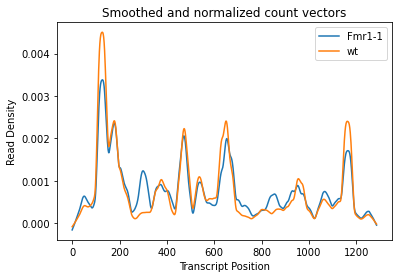

In [39]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

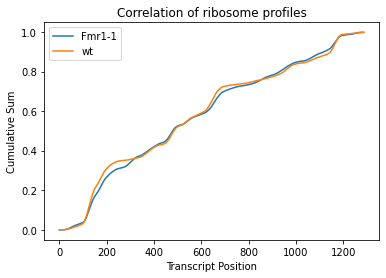

In [40]:
plt.plot(my_position, cumul_m, label = "Fmr1-1")
plt.plot(my_position, cumul_c, label = "wt")
plt.ylabel("Cumulative Sum")
plt.xlabel("Transcript Position")
plt.title("Correlation of ribosome profiles")
plt.legend()

In [47]:
stats.ks_2samp(my_vec_mutant/sum(my_vec_mutant), my_vec_control/sum(my_vec_control))

KstestResult(statistic=0.2400932400932401, pvalue=5.987028223745434e-33)

In [48]:
stats.pearsonr(cumul_m,cumul_c)

(0.9985050360545874, 0.0)

Wait a second, if I am using the cumulative sum for these KS-tests than wouldn't the P-values scale up with the length of the transcript since the function is going to take the number of inputs as the number of independent samples? like, if it sees a bunch of zeroes it is going to think that we actually ran a test and got a bunch of zeroes wont it? and this would apply to the normal data too. 